# Exercise 9: Knowledge Extraction from a Convolutional Neural Network

In the following exercise we will train a convolutional neural network to classify electron microscopy images of Drosophila synapses, based on which neurotransmitter they contain. We will then train a CycleGAN and use a method called Discriminative Attribution from Counterfactuals (DAC) to understand how the network performs its classification, effectively going back from prediction to image data.

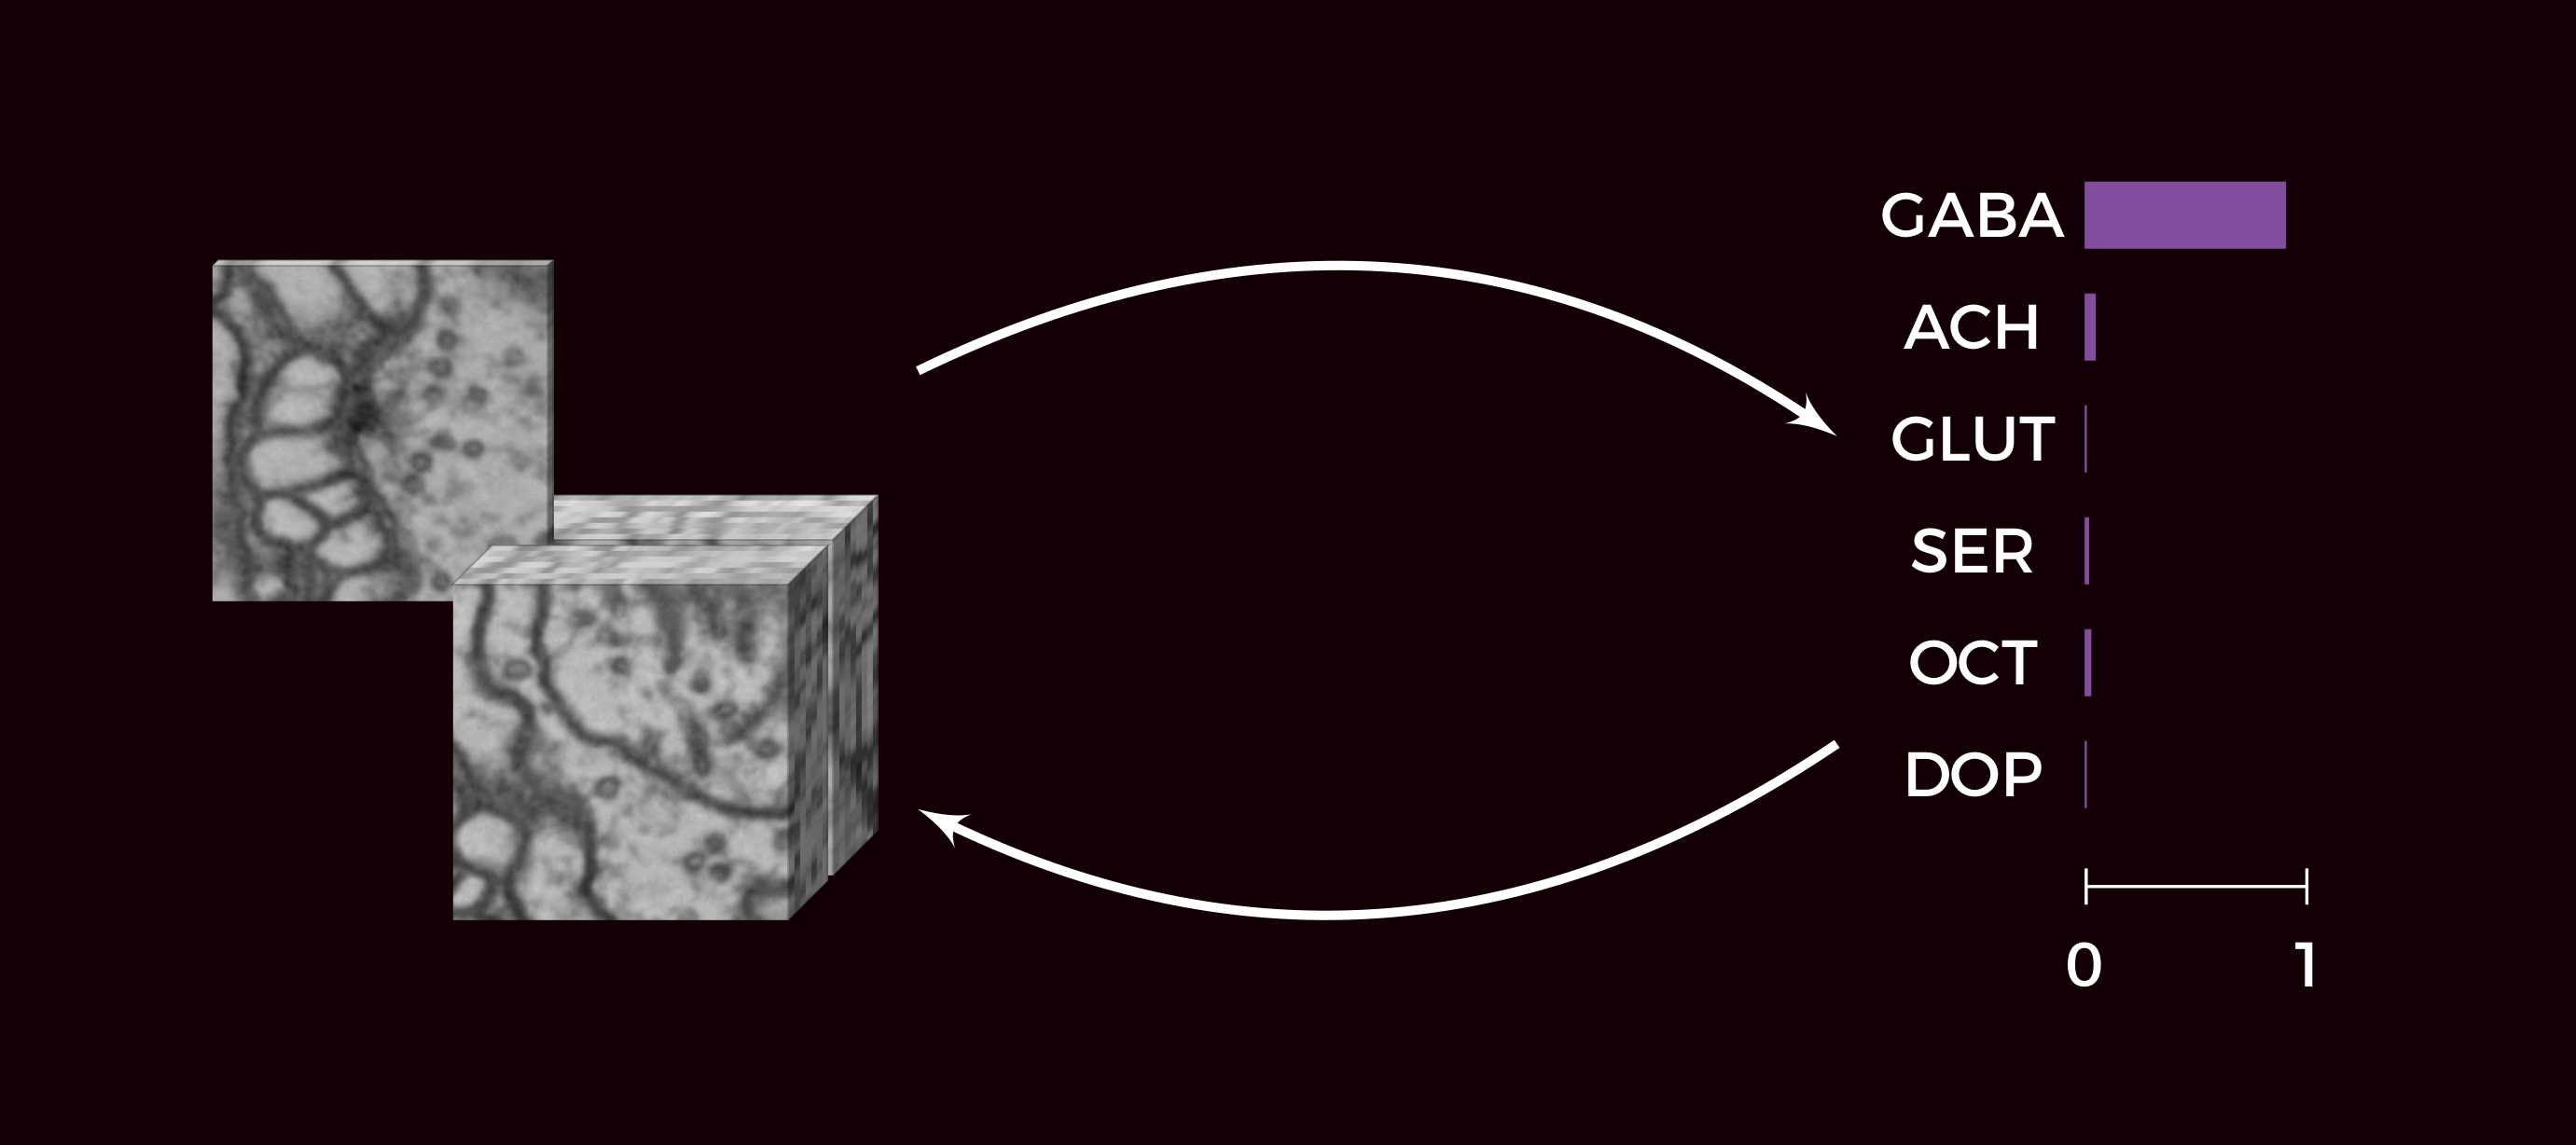

### Installation

This exercise will use packages including `numpy`, `scikit-image`, and `torch` (and a library called `dominate` for the CycleGAN). Execute the next cell to install those requirements in your current conda environment and to download the datasets we will use. This needs to be done only once.

### Acknowledgments

This notebook was written by Jan Funke and modified by Tri Nguyen, using code from Nils Eckstein and a modified version of the [CycleGAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) implementation.


In [ ]:
# requirements
!pip install numpy scikit-image torch torchvision dominate matplotlib tqdm captum opencv-python seaborn sklearn pandas

# # get the CycleGAN code and dependencies
!git clone https://github.com/funkey/neuromatch_xai
!mv neuromatch_xai/cycle_gan .
# !git clone https://github.com/funkelab/DAC
# !mv DAC/dac .
# !mv DAC/dac_networks .

# download the resources for this tutorial (one zip file)
!wget 'https://www.dropbox.com/sh/ucpjfd3omjieu80/AAAvZynLtzvhyFx7_jwVhUK2a?dl=0&preview=data.zip' -O resources.zip
# unzip the 'synapses' dataset and model checkpoints
# (this will take a while)
!unzip -o resources.zip data.zip
!unzip -o resources.zip checkpoints.zip
!unzip -o data.zip 'data/raw/synapses/*'
!unzip -o checkpoints.zip 'checkpoints/synapses/*'
# make sure the order of classes matches the pretrained model
!mv data/raw/synapses/gaba data/raw/synapses/0_gaba      
!mv data/raw/synapses/acetylcholine data/raw/synapses/1_acetylcholine
!mv data/raw/synapses/glutamate data/raw/synapses/2_glutamate 
!mv data/raw/synapses/serotonin data/raw/synapses/3_serotonin 
!mv data/raw/synapses/octopamine data/raw/synapses/4_octopamine 
!mv data/raw/synapses/dopamine data/raw/synapses/5_dopamine

## Part 1: Image Classification

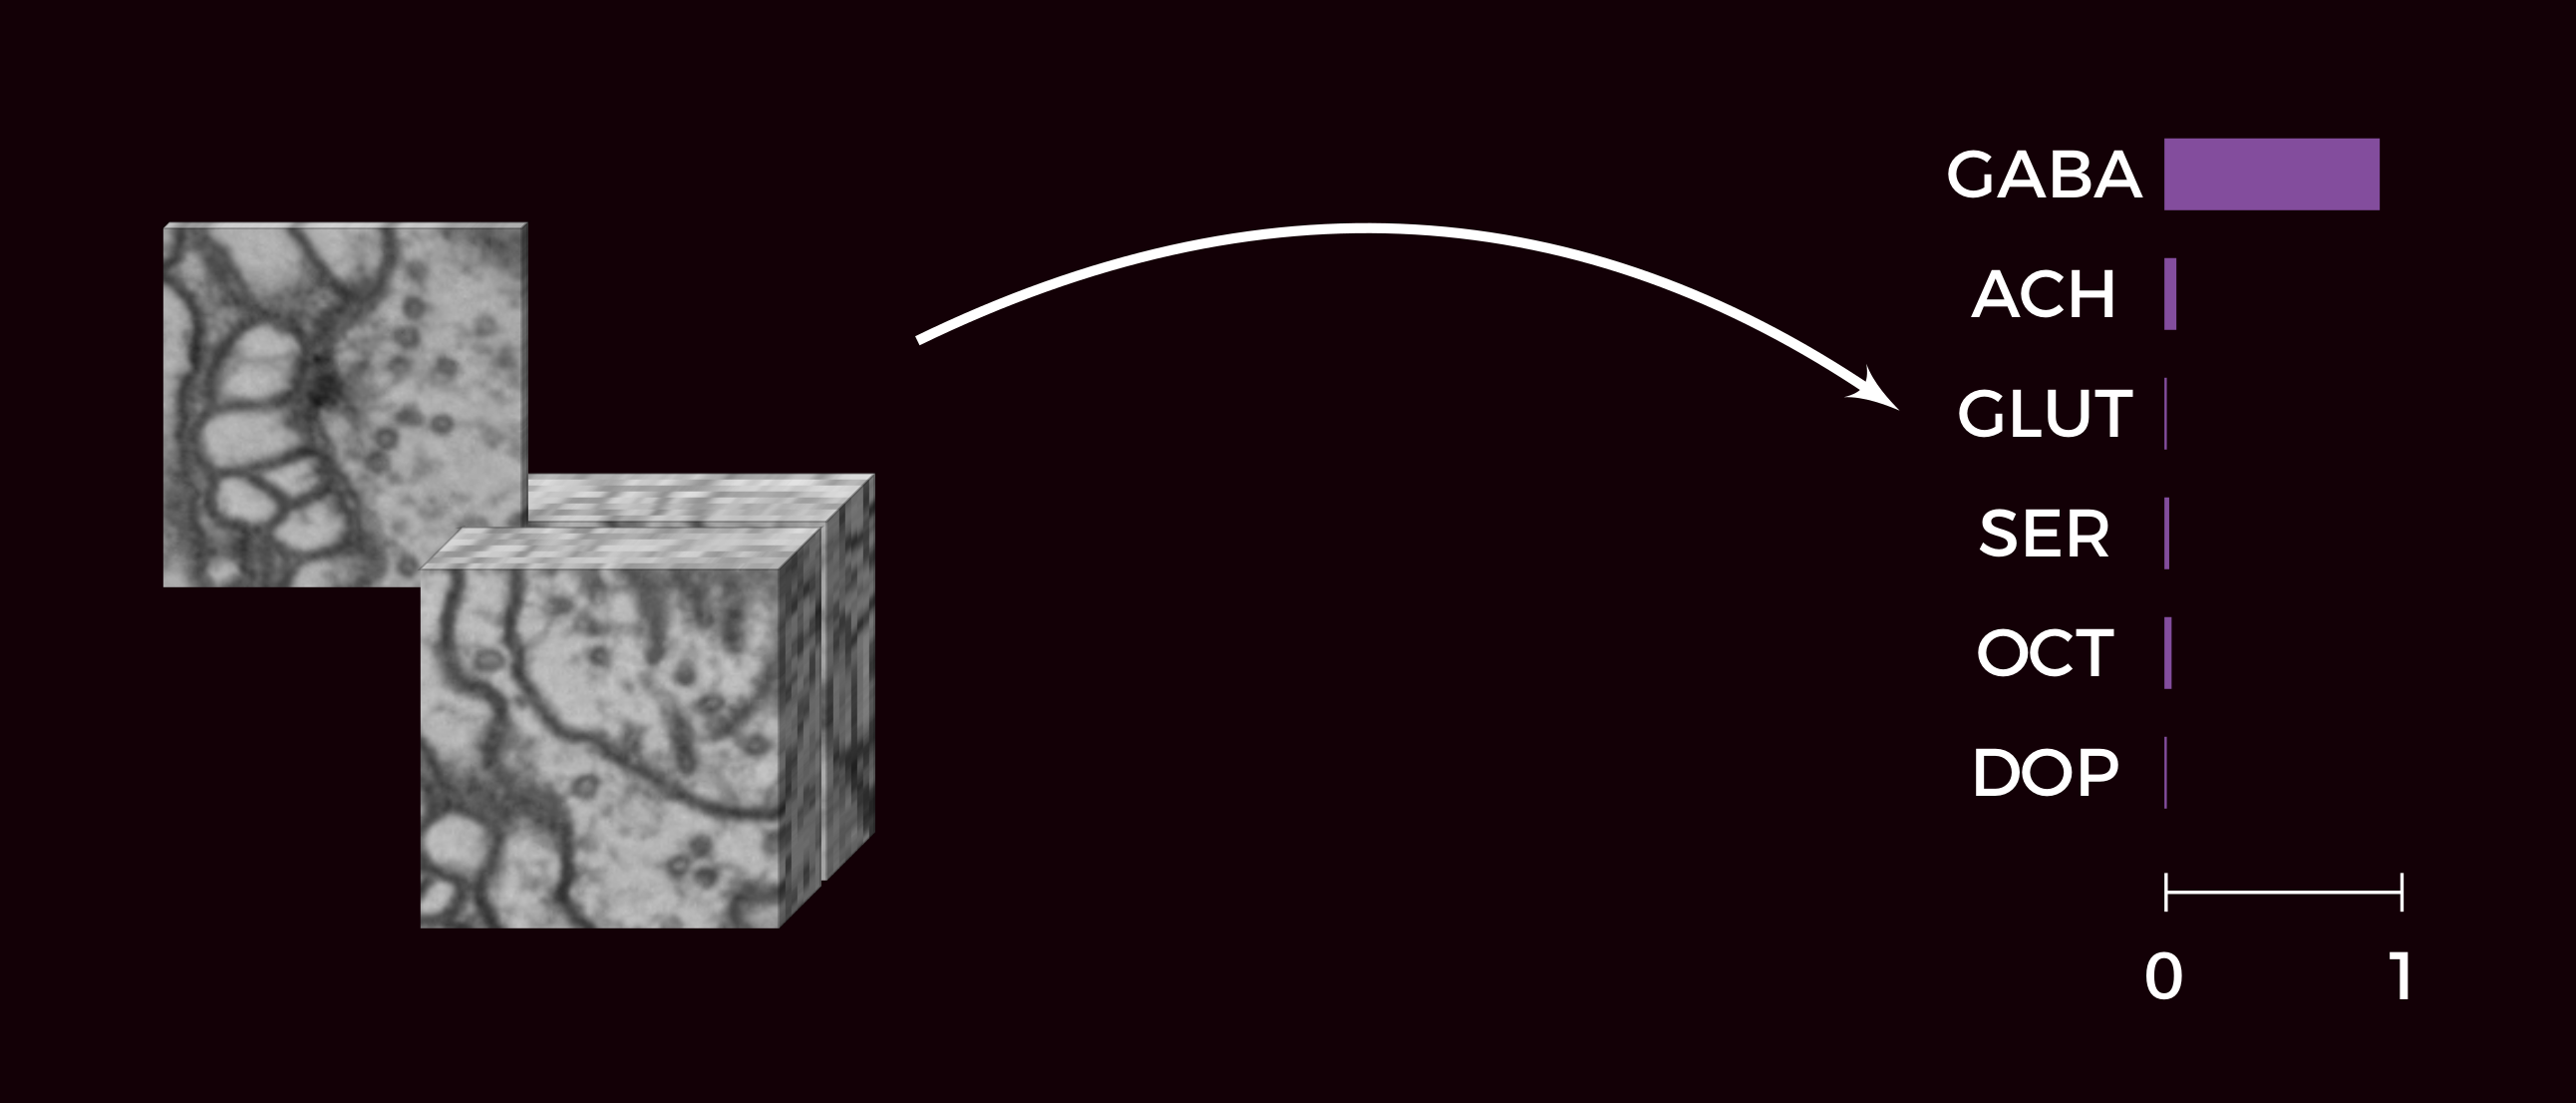

### Task 1: Train an Image Classifier

In this section, we will implement and train a VGG classifier to classify images of synapses into one of six classes, corresponding to the neurotransmitter type that is released at the synapse: GABA, acethylcholine, glutamate, octopamine, serotonin, and dopamine.

#### Task 1.1: Create a Balanced Dataloader

The data we use for this exercise is located in `data/raw/synapses`, where we have one subdirectory for each neurotransmitter type. Look at a few examples to familiarize yourself with the dataset. You will notice that the dataset is not balanced, i.e., we have much more examples of one class versus another one.

This class imbalance is problematic for training a classifier. Imagine that 99% of our images are of one class, then the classifier would do really well predicting this class all the time, without having learnt anything of substance. It is therefore important to balance the dataset, i.e., present the same number of images per class to the classifier during training.

First, we split the available images into a train, validation, and test dataset with proportions of 0.7, 0.15, and 0.15, respectively. Each image should be returned as a 2D `numpy` array with float values between 0 and 1. The label for each image should be the name of the directory for this class (e.g., `0_gaba`).

In [26]:
from skimage.io import imread
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
import torch
import numpy as np

def load_image(filename):
    
    image = imread(filename)
    
    # images are grescale, we only need one of the RGB channels 
    image = image[:, :, 0]
    
    # img is uint8 in [0, 255], but we want float32 in [-1, 1]
    image = image.astype(np.float32)/255.0
    image = (image - 0.5)/0.5
    
    return image

# create a dataset for all images of all classes
full_dataset = ImageFolder(root='data/raw/synapses', loader=load_image)

# randomly split the dataset into train, validation, and test
num_images = len(full_dataset)
# ~70% for training
num_training = int(0.7 * num_images)
# ~15% for validation
num_validation = int(0.15 * num_images)
# ~15% for testing
num_test = num_images - (num_training + num_validation)
# split the data randomly (but with a fixed random seed)
train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset,
    [num_training, num_validation, num_test],
    generator=torch.Generator().manual_seed(23061912))

To make training balance, we'll need to define a `sampler` that sample images of classes with skewed probabilities. Call your `sampler` variable `sampler`.
##### Hints
* look in `torch.utils.data.sampler` for a class that helps to balance the dataset during training
* instead of picking first a class and then an image in this class, we can also pick each image with a different probability

In [57]:
# Default sampler: this one returns a random sample of the entire dataset and will result in class imbalance during training
sampler = torch.utils.data.sampler.RandomSampler(train_dataset)

# insert your solution here
# sampler = ...

In [67]:
#########################
# Solution for Task 1.1 #
#########################

# compute class weights in training dataset for uniform sampling
ys = np.array([y for _, y in train_dataset.dataset.imgs])
counts = np.bincount(ys)
label_weights = 1.0 / counts
weights = label_weights[ys]

print("Number of images per class:")
for c, n, w in zip(full_dataset.classes, counts, label_weights):
    print(f"\t{c}:\tn={n}\tweight={w}")

# create a data loader with uniform sampling
sampler = WeightedRandomSampler(weights, len(weights))

Number of images per class:
	0_gaba:	n=22648	weight=4.415400918403391e-05
	1_acetylcholine:	n=7000	weight=0.00014285714285714287
	2_glutamate:	n=5085	weight=0.00019665683382497542
	3_serotonin:	n=3312	weight=0.00030193236714975844
	4_octopamine:	n=1315	weight=0.0007604562737642585
	5_dopamine:	n=6659	weight=0.0001501726986033939


Finally, we make a `torch` `DataLoader` that takes our `sampler` to create batches of eight images and their corresponding labels. Each image should be randomly and equally selected from the six available classes (i.e., for each image sample pick a random class, then pick a random image from this class).

In [77]:
# this data loader will serve 8 images in a "mini-batch" at a time
dataloader = DataLoader(train_dataset, batch_size=8, drop_last=True, sampler=sampler)

The cell below visualizes a single, randomly chosen batch from the training data loader. Feel free to execute this cell multiple times to get a feeling for the dataset and that your sampler gives batches of evenly distributed synapse types.

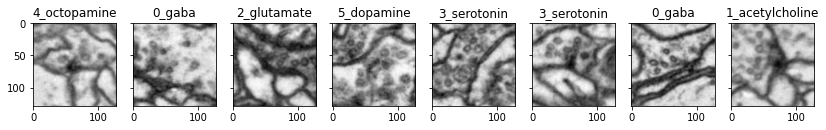

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt

def show_batch(x, y):
    fig, axs = plt.subplots(1, x.shape[0], figsize=(14, 14), sharey=True)
    for i in range(x.shape[0]):
        axs[i].imshow(np.squeeze(x[i]), cmap='gray')
        axs[i].set_title(train_dataset.dataset.classes[y[i].item()])
    plt.show()

# show a random batch from the data loader
# (run this cell repeatedly to see different batches)
for x, y in dataloader:
    show_batch(x, y)
    break

#### Task 1.2: Create a VGG Network, Loss, and Optimizer

We will use a so-called VGG network to classify the synapse images. The input to the network will be a 2D image as provided by your dataloader. The output will be a vector of six floats, corresponding to the probability of the input to belong to the six classes.

Implement a VGG network with the following specificatons:

* the constructor takes the size of the 2D input image as height and width
* the network starts with a downsample path consisting of:
    * one convolutional layer, kernel size (3, 3), to create 12 feature maps
    * batch norm in 2D over those feature maps
    * ReLU activation function
    * one convolutional layer, kernel size (3, 3), to create 12 feature maps
    * batch norm in 2D over those feature maps
    * ReLU activation function
    * max pool downsampling with a factor of (2, 2)
* followed by three more downsampling paths like the one above, every time doubling the number of feature maps (i.e., the second one will have 24, the third 48, and the fourth 96)
* then two fully connected layers with:
    * 4096 units
    * ReLU activation function
    * drop out
* finally, one more fully connected layer with
    * 6 units (these correspond to the classes)
    * no activation function

Implement this network as a `torch.nn.Module` and call the class `Vgg2D`.

In [3]:
class Vgg2D(torch.nn.Module):
    
    # insert your solution here
    pass

In [4]:
#########################
# Solution for Task 1.2 #
#########################

class Vgg2D(torch.nn.Module):

    def __init__(
            self,
            input_size,
            fmaps=12,
            downsample_factors=[(2, 2), (2, 2), (2, 2), (2, 2)],
            output_classes=6):

        super(Vgg2D, self).__init__()

        self.input_size = input_size

        current_fmaps = 1
        current_size = tuple(input_size)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv2d(
                    current_fmaps,
                    fmaps,
                    kernel_size=3,
                    padding=1),
                torch.nn.BatchNorm2d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(
                    fmaps,
                    fmaps,
                    kernel_size=3,
                    padding=1),
                torch.nn.BatchNorm2d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool2d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(
                current_size[0] *
                current_size[1] *
                current_fmaps,
                4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(
                4096,
                4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(
                4096,
                output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        shape = tuple(raw.shape)
        raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

In [5]:
# get the size of our images
for x, y in train_dataset:
    input_size = x.shape
    break

# create the model to train
model = Vgg2D(input_size)

# create a loss
loss = torch.nn.CrossEntropyLoss()

# create an optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#### Task 1.3: Train the VGG Network

In [6]:
# use a GPU, if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Will use device {device} for training")

Will use device cuda for training


The next cell merely defines some convenience functions for training, validation, and testing:

In [7]:
from tqdm import tqdm

def train():
    '''Train the model for one epoch.'''

    # set the model into train mode
    model.train()

    epoch_loss = 0

    num_batches = 0
    for x, y in tqdm(dataloader, 'train'):

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()

        optimizer.step()

        epoch_loss += l
        num_batches += 1

    return epoch_loss/num_batches

def evaluate(dataloader, name):
    
    correct = 0
    total = 0
    for x, y in tqdm(dataloader, name):
        
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        probs = torch.nn.Softmax(dim=1)(logits)
        predictions = torch.argmax(probs, dim=1)
        
        correct += int(torch.sum(predictions == y).cpu().detach().numpy())
        total += len(y)
    
    accuracy = correct/total

    return accuracy

def validate():
    '''Evaluate prediction accuracy on the validation dataset.'''
    
    model.eval()
    dataloader = DataLoader(validation_dataset, batch_size=32)
   
    return evaluate(dataloader, 'validate')

def test():
    '''Evaluate prediction accuracy on the test dataset.'''
    
    model.eval()
    dataloader = DataLoader(test_dataset, batch_size=32)
    
    return evaluate(dataloader, 'test')

We are ready to train. After each epoch (roughly going through each training image once), we report the training loss and the validation accuracy.

In [ ]:
for epoch in range(100):
    
    epoch_loss = train()
    print(f"epoch {epoch}, training loss={epoch_loss}")
    
    accuracy = validate()
    print(f"epoch {epoch}, validation accuracy={accuracy}")

Feel free to watch your model train... 
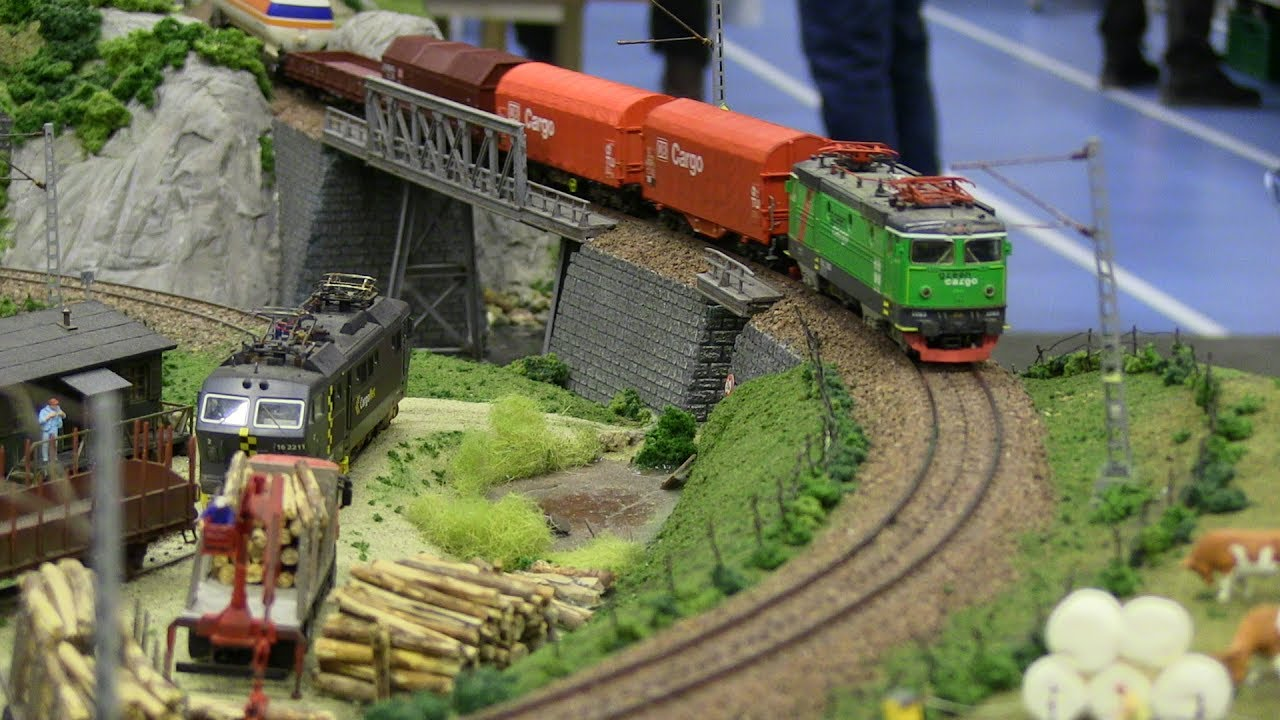

Or interrupt the current cell and run the next one, which will load a checkpoint that we already prepared.

In [9]:
# SHORTCUT (OPTIONAL): load a pretrained model

# change this to True and run this cell if you want a shortcut
yes_I_want_the_pretrained_model = False

if yes_I_want_the_pretrained_model:
    checkpoint = torch.load('checkpoints/synapses/classifier/vgg_checkpoint', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

In [10]:
accuracy = test()
print(f"final test accuracy: {accuracy}")

test: 100%|█████████████████████████████████████████████████████████████| 216/216 [00:10<00:00, 20.36it/s]

final test accuracy: 0.8054750869061413


#### Task 1.4: Construct a confusion matrix

We now have a classifier that can discriminate between images of different types. If you used the images we provided, the classifier is not perfect (you should get an accuracy of around 80%), but pretty good considering that there are six different types of images.

To understand the performance of the classifier beyond a single accuracy number, we should build a confusion matrix that can more elucidate which classes are more/less misclassified and which classes are those wrong predictions confused with. You should get something like this:

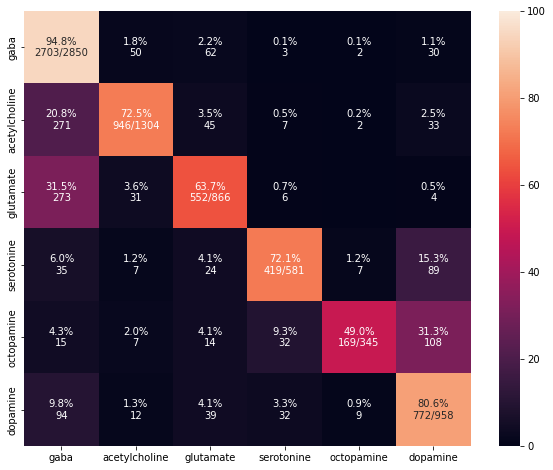

In [11]:
# insert your solution here
# hint: modify test() and evaluate() to return a paired list of predicted class vs groundtruth to produce a confusion matrix

In [12]:
#########################
# Solution for Task 1.4 #
#########################

from tqdm import tqdm

def evaluate_cm(dataloader, name):
    
    correct = 0
    total = 0
    ys = []
    preds = []
    for x, y in tqdm(dataloader, name):
        
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        probs = torch.nn.Softmax(dim=1)(logits)
        batch_predictions = torch.argmax(probs, dim=1)
        
        # append predictions and groundtruth to our big list,
        # converting `tensor` objects to simple values through .item()
        preds.extend([k.item() for k in batch_predictions])
        ys.extend([k.item() for k in y])
    
    return (preds, ys)

def test_cm():
    '''Evaluate prediction accuracy on the test dataset.'''
    
    model.eval()
    dataloader = DataLoader(test_dataset, batch_size=32)
    
    return evaluate_cm(dataloader, 'test')

prediction, groundtruth = test_cm()

test: 100%|█████████████████████████████████████████████████████████████| 216/216 [00:11<00:00, 19.60it/s]


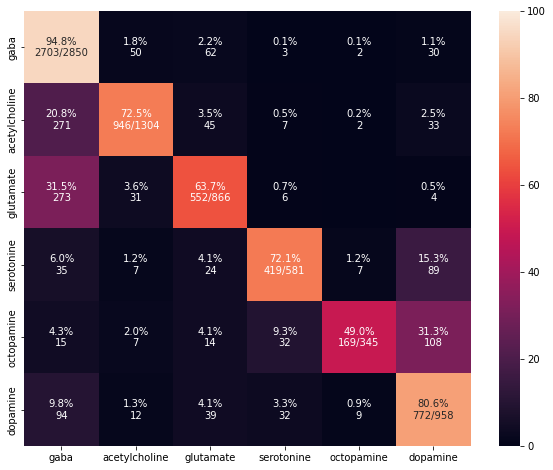

In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title=None, figsize=(10,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ["gaba", "acetylcholine", "glutamate", "serotonine", "octopamine", "dopamine"]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax=sns.heatmap(cm_perc, annot=annot, fmt='', vmax=100, xticklabels=labels, yticklabels=labels)
    if title:
        ax.set_title(title)

cm_analysis(prediction, groundtruth)

What observations can we make from the confusion matrix? Does the classifier do better on some synapse classes than other? Would it overpredict certain classes at the expense of other classes? What is the bias? If you have time later, which ideas would you try to train a better predictor?

This concludes the first section. We now have trained a pretty good class predictor. It is not so clear though for humans how the classifier does it. Feel free to explore the data a bit more and see for yourself if you can tell the difference betwee, say, GABAergic and glutamatergic synapses.

So this is an interesting situation: The VGG network knows something we don't quite know. In the next section, we will see how we can visualize the relevant differences between images of different types.

## Part 2: Train a GAN to Translate Images

To gain insight into how the trained network classify images, we will use [Discriminative Attribution from Counterfactuals](https://arxiv.org/abs/2109.13412), a feature attribution with counterfactual explanations methodology. This method employs a so-called CycleGAN to translate images from one class to another to make counterfactual explanations.

In this example, we will train a CycleGAN network that translates GABAergic synapses to acetylcholine synapses (you can also train other pairs too by changing the below classes).

In [14]:
synapse_classes = ['gaba', 'acetylcholine', 'glutamate', 'serotonine', 'octopamine', 'dopamine']

def class_dir(name):
    return f'{synapse_classes.index(name)}_{name}'

class_A = 'gaba'
class_B = 'acetylcholine'

First, we have to copy images of either type into a format that the CycleGAN library is happy with. Afterwards, we can start training on those images.

In [15]:
# prepare a suitable data directory for training
import cycle_gan
cycle_gan.prepare_dataset('data/raw/synapses/', [class_dir(class_A), class_dir(class_B)])
# move data to a training folder
!mkdir -p training_data/cycle_gan
!mv data/raw/synapses/cycle_gan/{class_dir(class_A)}_{class_dir(class_B)} training_data/cycle_gan/{class_dir(class_A)}_{class_dir(class_B)}
!rmdir data/raw/synapses/cycle_gan

100%|██████████████████████████████████████████████████████████████| 7000/7000 [00:00<00:00, 14647.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [16]:
# and run training
cycle_gan.train('training_data/', class_dir(class_A), class_dir(class_B), 128)

Storing checkpoints of this training in checkpoints/resnet_9blocks_0_gaba_1_acetylcholine
----------------- Options ---------------
           aux_checkpoint: None                          
              aux_class_A: 0                             
              aux_class_B: 0                             
             aux_input_nc: 1                             
           aux_input_size: 128                           
                  aux_net: None                          
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: checkpoints/resnet_9blocks_0_gaba_1_acetylcholine	[default: ./checkpoints]
           continue_train: False                         
                crop_size: 128                           
                 dataroot: training_data/cycle_gan/0_gaba_1_acetylcholine	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB       

KeyboardInterrupt: 

...this time again.
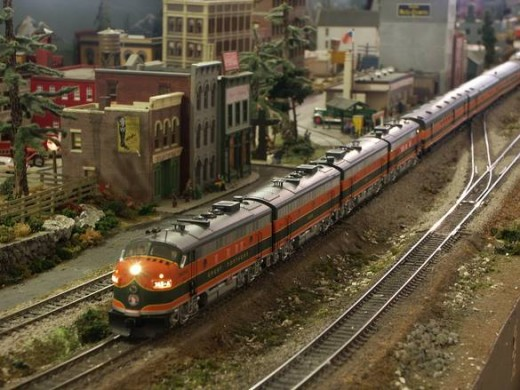

Training the CycleGAN takes a lot longer than the VGG we trained above (on the synapse dataset, this will be around 7 days...).

To continue, interrupt the kernel and continue with the next one, which will just use one of the pretrained CycleGAN models for the synapse dataset.

In [17]:
# translate images from class A to B, and classify each with the VGG network trained above
cycle_gan.test(
    data_dir='training_data/',
    class_A=class_dir(class_A),
    class_B=class_dir(class_B),
    img_size=128,
    checkpoints_dir=f'checkpoints/synapses/cycle_gan/{class_A}_{class_B}/',
    vgg_checkpoint='checkpoints/synapses/classifier/vgg_checkpoint'
)

----------------- Options ---------------
             aspect_ratio: 1.0                           
           aux_checkpoint: checkpoints/synapses/classifier/vgg_checkpoint	[default: None]
   aux_downsample_factors: [(2, 2), (2, 2), (2, 2), (2, 2)]
             aux_input_nc: 1                             
           aux_input_size: 128                           
                  aux_net: vgg2d                         
       aux_output_classes: 6                             
               batch_size: 1                             
          checkpoints_dir: checkpoints/synapses/cycle_gan/gaba_acetylcholine	[default: ./checkpoints]
                crop_size: 128                           
                 dataroot: training_data/cycle_gan/0_gaba_1_acetylcholine	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest   

processing (0005)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10004_train.png']
processing (0010)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10009_train.png']
processing (0015)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10013_train.png']
processing (0020)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10018_train.png']
processing (0025)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10022_train.png']
processing (0030)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10027_train.png']
processing (0035)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10031_train.png']
processing (0040)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10

processing (0335)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10301_train.png']
processing (0340)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10306_train.png']
processing (0345)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10310_train.png']
processing (0350)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10315_train.png']
processing (0355)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/1031_train.png']
processing (0360)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10324_train.png']
processing (0365)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/10329_train.png']
processing (0370)-th image... ['training_data/cycle_gan/0_gaba_1_acetylcholine/0_gaba_1_acetylcholine/trainA/103

In [18]:
import glob
import json

result_dir = f'training_data/cycle_gan/{class_dir(class_A)}_{class_dir(class_B)}/results/test_latest/images/'
classification_results = []
for f in glob.glob(result_dir + '/*.json'):
    result = json.load(open(f))
    result['basename'] = f.replace('_aux.json', '')
    classification_results.append(result)
classification_results.sort(
    key=lambda c: c['aux_real'][synapse_classes.index(class_A)] * c['aux_fake'][synapse_classes.index(class_B)],
    reverse=True)

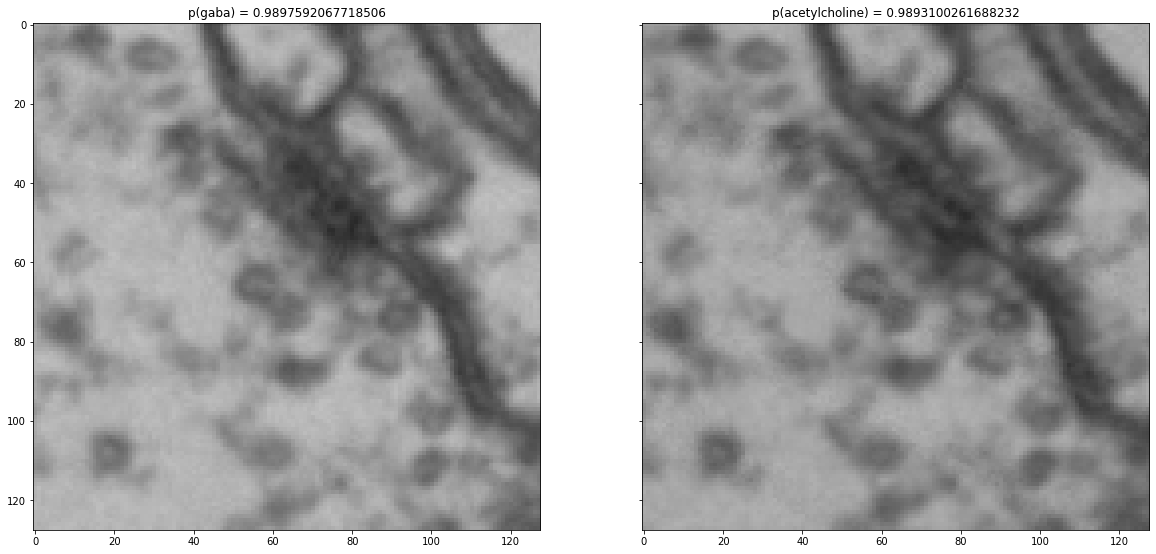

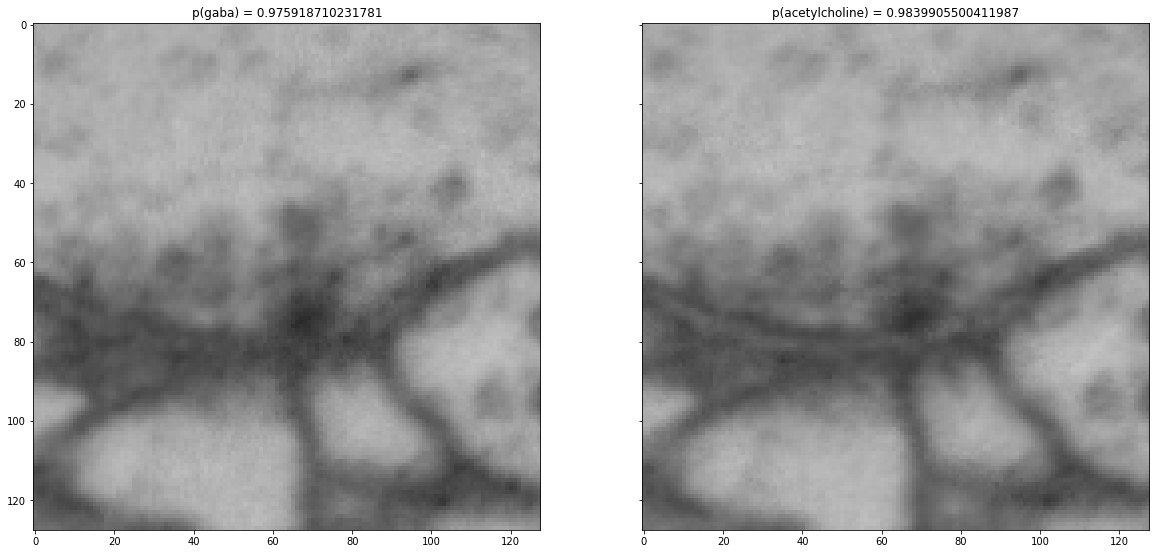

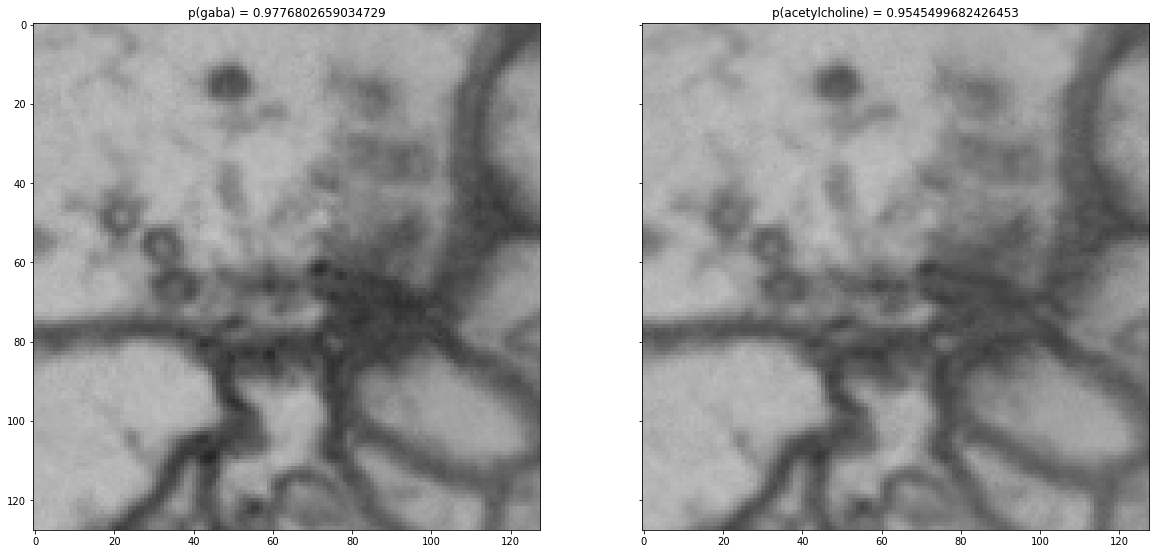

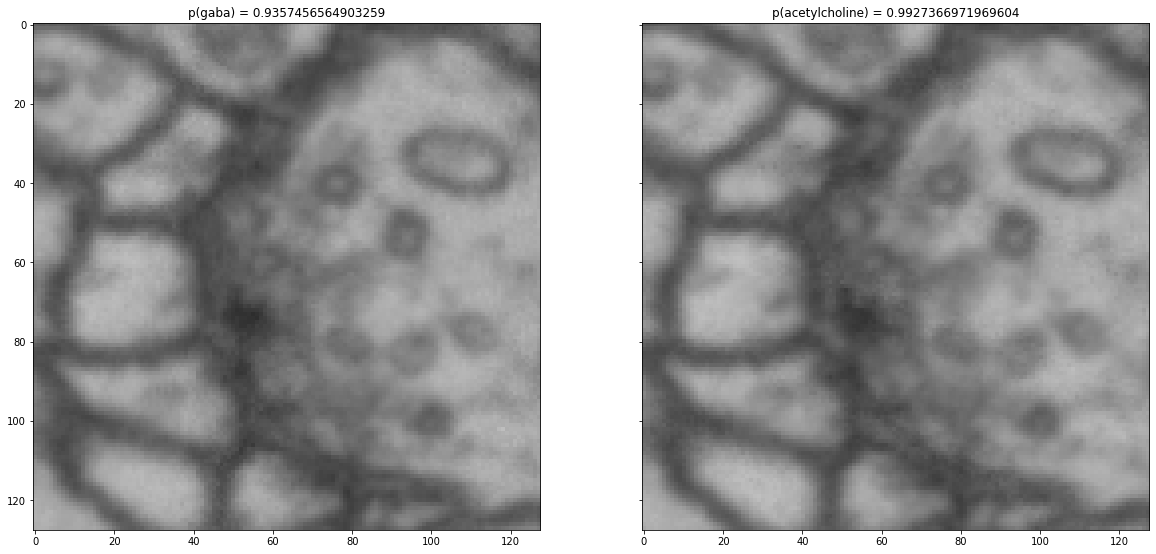

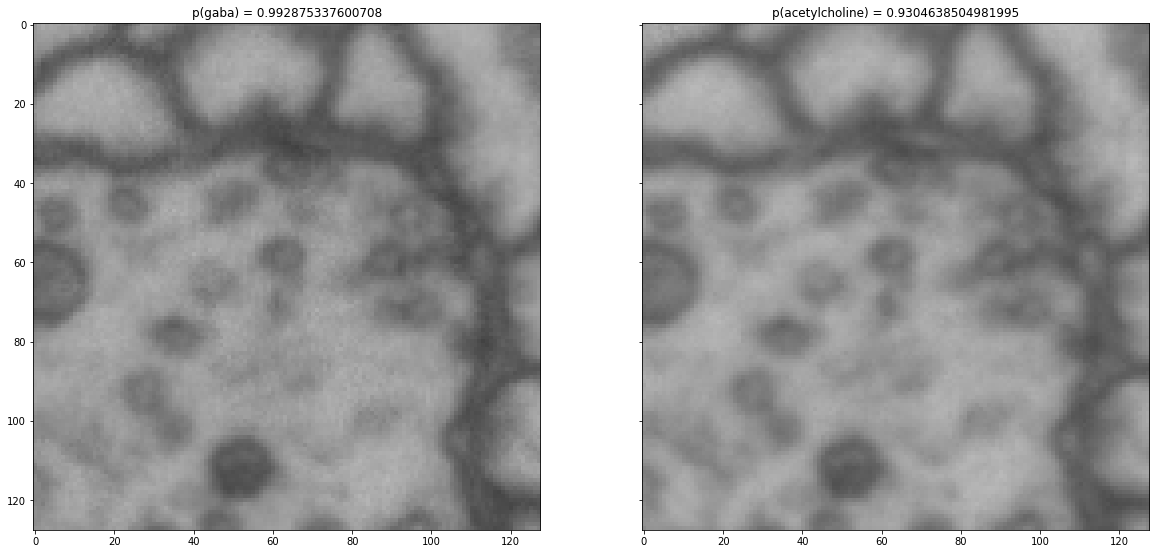

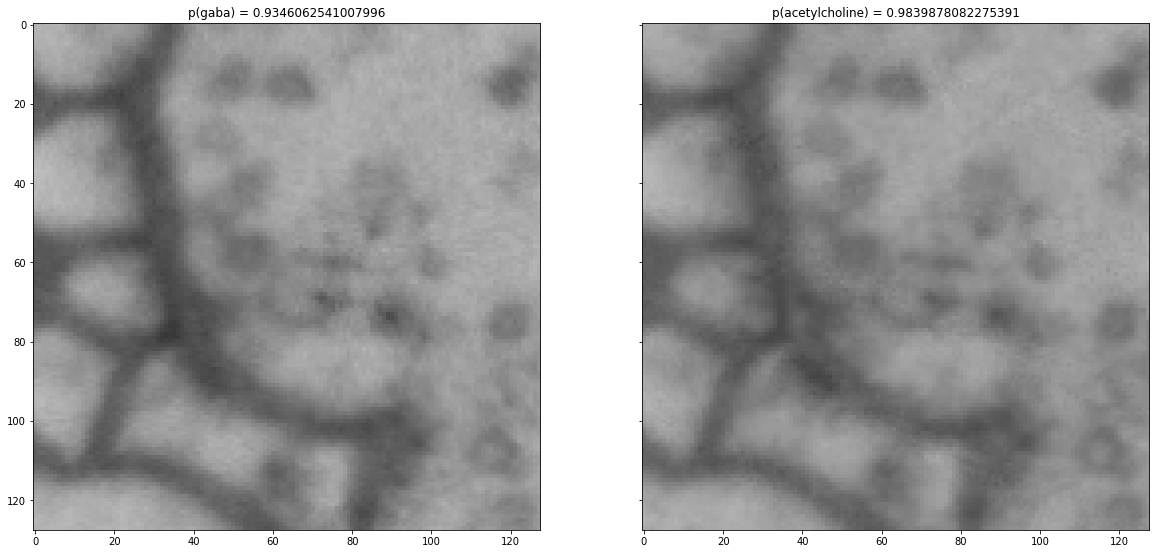

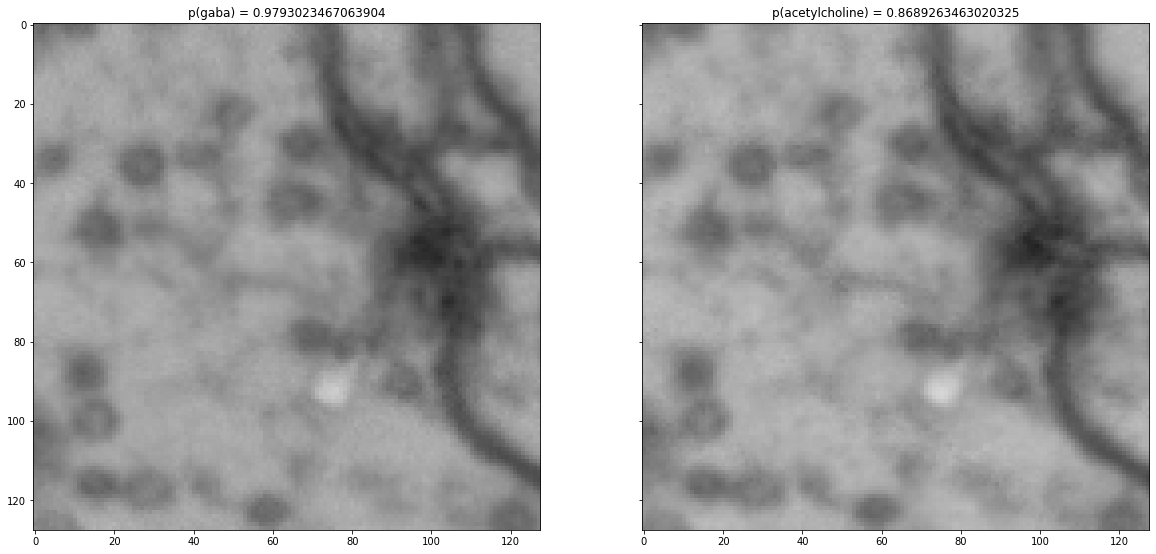

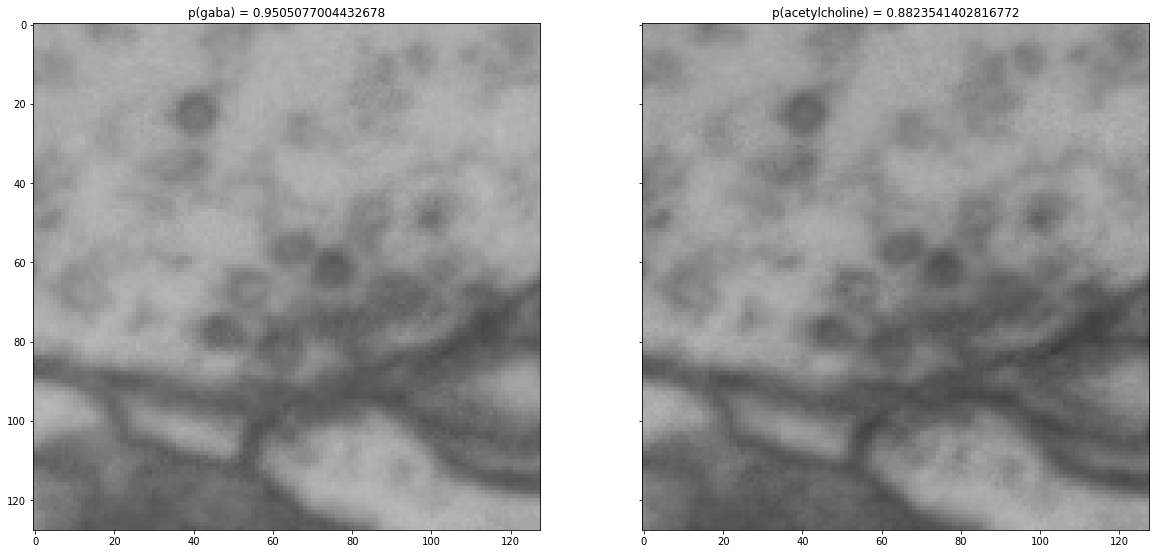

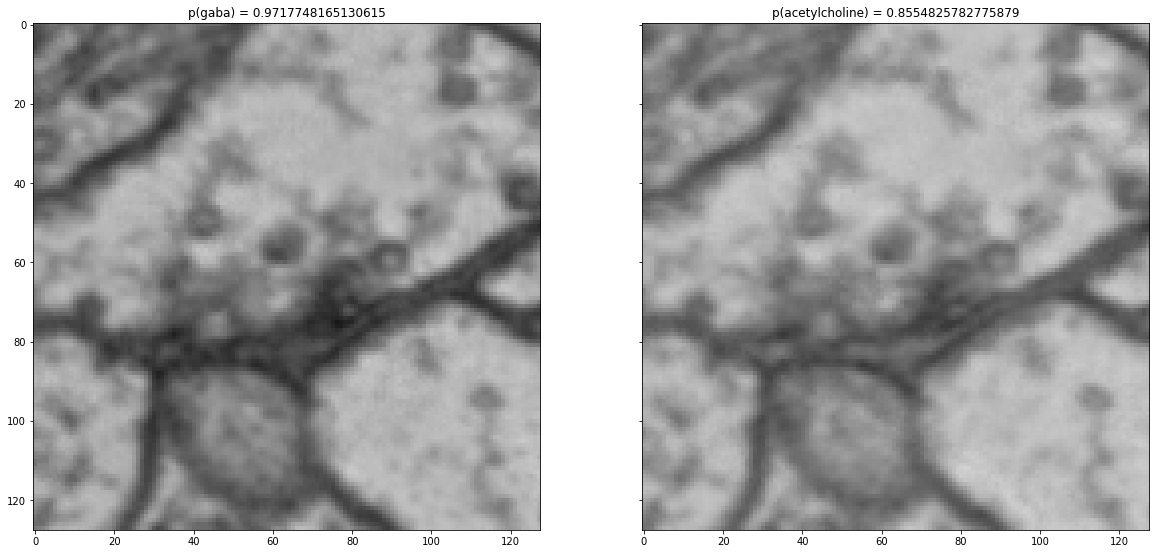

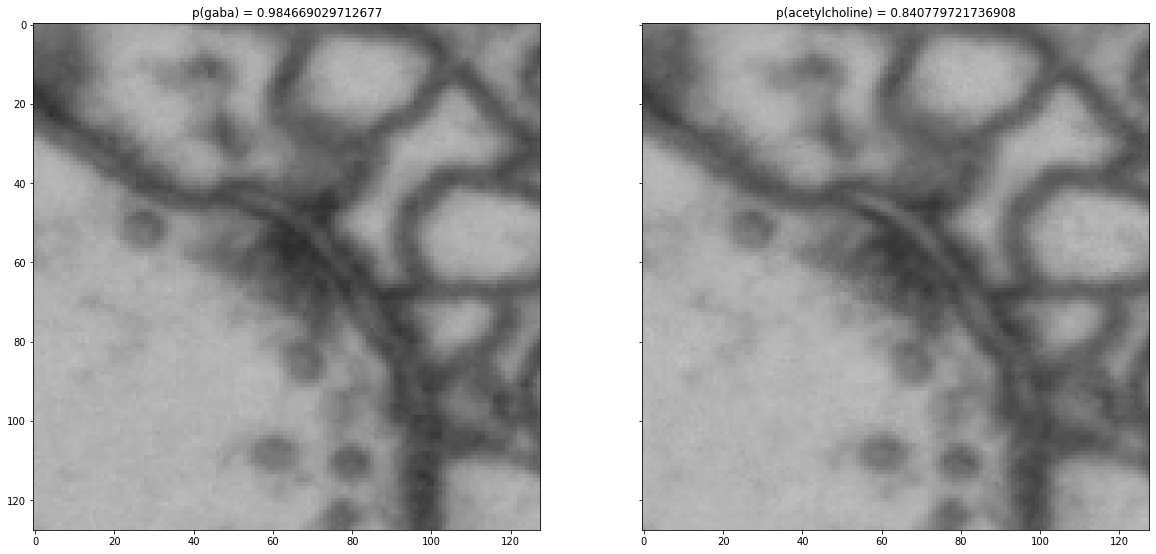

In [19]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

def show_pair(a, b, score_a, score_b, class_a, class_b):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20), sharey=True)
    axs[0].imshow(a, cmap='gray')
    axs[0].set_title(f"p({class_a}) = " + str(score_a))
    axs[1].imshow(b, cmap='gray')
    axs[1].set_title(f"p({class_b}) = " + str(score_b))
    plt.show()

# show the top successful translations (according to our VGG classifier)
for i in range(10):
    basename = classification_results[i]['basename']
    score_A = classification_results[i]['aux_real'][synapse_classes.index(class_A)]
    score_B = classification_results[i]['aux_fake'][synapse_classes.index(class_B)]
    real_A = imread(basename + '_real.png')
    fake_B = imread(basename + '_fake.png')
    show_pair(real_A, fake_B, score_A, score_B, class_A, class_B)

Here, we see that our CycleGAN network had successfully translated some GABA synapses and fooled the predictor network to classify them as acetylcholine. Remarkably, the differences between the "real" inputs and the "fake" outputs are minimal quanlitatively. Can you try going through a few pairs to see what differences between the real and fake are consistent?

This is the end of Section 2. Unfortunately, at this point, we still don't know how a GAN modifies the images, nor how a classifier looks at which specific features to determine classes. To understand this question, we will combine the results of these two networks through a feature attribution method.

# Section 3: Highlighting Class-Relevant Differences

In this section we will use a "Discriminative Attribution from Counterfactuals" (DAC) method to highlight differences between the "real" and "fake" images that are most important to change the decision of the classifier. The below code is runnable without modfications, and for each paired real/fake example, shows the "attribution" (which modified pixels are contributing the most to a classification decision), and a "mask" (which region of the fake output that once copied over to the real input would flip the decision of the classifier).

With the highlight localized to a smaller region of the images, can you now identify the defining features of the synapses? Feel free to change synapse class pairing and observe their differences.

training_data/cycle_gan/0_gaba_1_acetylcholine/results/test_latest/images/10006_train


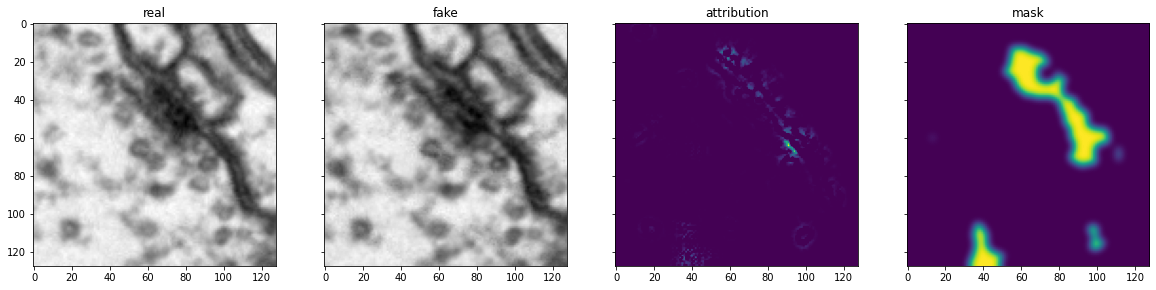

training_data/cycle_gan/0_gaba_1_acetylcholine/results/test_latest/images/10015_train


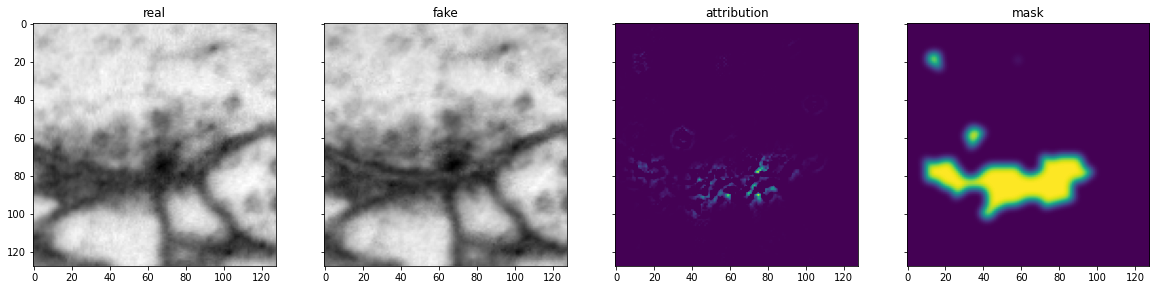

training_data/cycle_gan/0_gaba_1_acetylcholine/results/test_latest/images/1024_train


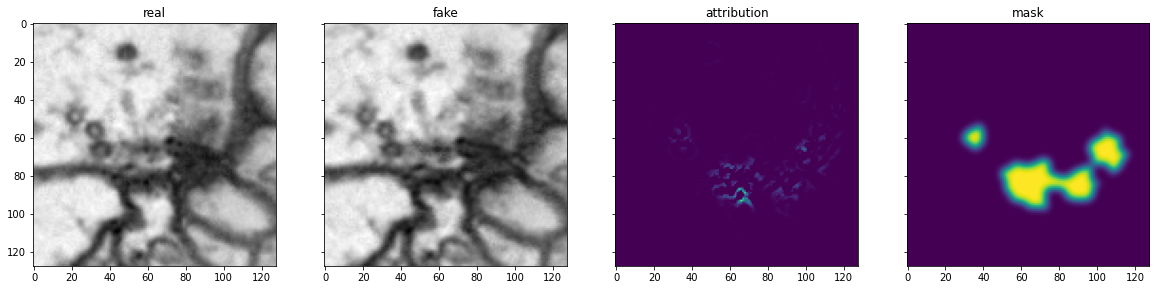

training_data/cycle_gan/0_gaba_1_acetylcholine/results/test_latest/images/10176_train


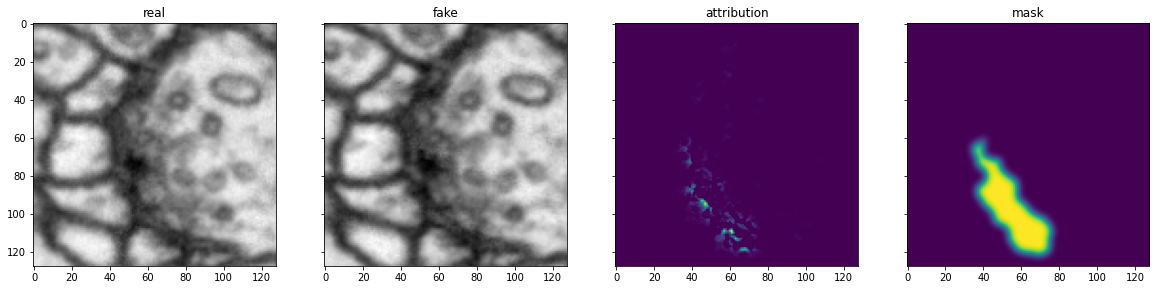

In [25]:
%matplotlib inline
import numpy as np
import dac
from dac.attribute import get_attribution
from dac.utils import open_image
from dac.mask import get_mask
from matplotlib import pyplot as plt

mask_thres_lo = 110
mask_thres_hi = 130
# method = 'ggc'
# methods = ['dl']
# methods = ['ig']
# methods = ['gc']  # looks kind of ok but some faults
# methods = ['ggc']  # mask too high?

method = 'ggc'
mask_thres_lo = 105
mask_thres_hi = 110

# method = 'dl'

# method = 'ingrad'
# mask_thres_lo = 125
# mask_thres_hi = 130

# method = 'residual'
# mask_thres_lo = 130
# mask_thres_hi = 140

downsample_factors = [(2, 2), (2, 2), (2, 2), (2, 2)]

def show_mask(real, fake, attribution, mask):
    fig, axs = plt.subplots(1, 4, figsize=(20, 20), sharey=True)
    axs[0].imshow(real, cmap='gray')
    axs[0].set_title("real")
    axs[1].imshow(fake, cmap='gray')
    axs[1].set_title("fake")
    axs[2].imshow(attribution, vmin=0.0, vmax=1.0)
    axs[2].set_title("attribution")
    axs[3].imshow(mask, vmin=0.0, vmax=1.0)
    axs[3].set_title("mask")
    plt.show()

for i in range(4):
    
    basename = classification_results[i]['basename']
    real_filename = basename + '_real.png'
    fake_filename = basename + '_fake.png'
    real_img = open_image(real_filename, flatten=True, normalize=False)
    fake_img = open_image(fake_filename, flatten=True, normalize=False)
    
    attribution_maps, names = dac.attribute.get_attribution(
        real_img, fake_img,
        synapse_classes.index(class_A), synapse_classes.index(class_B),
        'Vgg2D', 'checkpoints/synapses/classifier/vgg_checkpoint',
        (128, 128), 1,
        [method],
        6, downsample_factors)
    
    for attribution_map, name in zip(attribution_maps, names):
        
        if method == 'ggc':
            if name != 'd_ggc':
                continue
        elif method == 'ingrad':
            if name != 'ingrad':
                continue
        
        print(basename)
        result, names, images = get_mask(
            attribution_map, real_img, fake_img,
            synapse_classes.index(class_A), synapse_classes.index(class_B),
            'Vgg2D', 'checkpoints/synapses/classifier/vgg_checkpoint',
            (128, 128), 1,
            6, downsample_factors)

        for threshold in range(mask_thres_lo, mask_thres_hi, 5):
            show_mask(real_img, fake_img, images[threshold][0], images[threshold][7])

### Going Further

Here are some ideas for how to continue with this notebook:

1. Improve the classifier. This code uses a VGG network for the classification. On the synapse dataset, we will get a validation accuracy of around 80%. Try to see if you can improve the classifier accuracy.
    * (easy) Data augmentation: The training code for the classifier is quite simple in this example. Enlarge the amount of available training data by adding augmentations (transpose and mirror the images, add noise, change the intensity, etc.).
    * (easy) Network architecture: The VGG network has a few parameters that one can tune. Try a few to see what difference it makes.
    * (easy) Inspect the classifier predictions: Take random samples from the test dataset and classify them. Show the images together with their predicted and actual labels.
    * (medium) Other networks:  Try different architectures (e.g., a ResNet) and see if the accuracy can be improved.

2. Explore the CycleGAN.
    * (easy) The example code below shows how to translate between GABA and acetylcholine. Try different combinations, and also in the reverse direction. Can you start to see differences between some pairs of classes? Which are the ones where the differences are the most or the least obvious?
    * (hard) Watching the CycleGAN train can be a bit boring. Find a way to show (periodically) the current image and its translation to see how the network is improving over time. Hint: The `cycle_gan` module has a `Visualizer`, which might be helpful.

3. Try on your own data!
    * Have a look at how the synapse images are organized in `data/raw/synapses`. Copy the directory structure and use your own images. Depending on your data, you might have to adjust the image size (128x128 for the synapses) and number of channels in the VGG network and CycleGAN code.